In [8]:
import sys 
sys.path.append("..") 

#from topological_models import generator
import numpy as np
import numpy.linalg as LA

from topology_model import NonHermitianHamiltonian, NonHermitianTopologicalModel
import matplotlib.pyplot as plt
from machine_learning import Cluster
from machine_learning import Classifier
from topology_model import sigma_0, sigma_x, sigma_y, sigma_z
from topology_model import Generator
from topology_model import topology_comparator, topology_verifier, obtain_phase_center_and_number

$PT$-symmetry

In [2]:
class LossGain1D(NonHermitianHamiltonian):
    def __init__(self, E_ref=0.):
        super().__init__(E_ref)
        self.parameters = list()
        self.initiate()

    def get_n(self):
        '''
        n*n Hamiltonian
        '''
        return 4

    def get_n_dim(self):
        return 1

    def get_parameters(self):
        return self.parameters

    def set_parameters(self, **kwargs):
        self.parameters = kwargs['kappa'], kwargs['g1'], kwargs['g2']

    def get_kpoints(self):
        n_points = 11
        kpoints = [[k] for k in np.linspace(0,np.pi,n_points)]
        return kpoints

    def initiate(self):
        # different parameter region for the different gap type
        kappa = 1.
        g1 = -3 + 6*np.random.random()
        #gamma = 3*np.random.random()
        g2 = -3 + 6*np.random.random()

        self.parameters = kappa, g1, g2

    def is_real_line_gap(self):
        kappa, g1, g2 = self.parameters
        # if not ((t1 >= t2 + gamma/2) 
        #         or (t1 <= -t2 - gamma/2) 
        #         or ((t1 >= t2 - gamma/2) and (t1 <= -t2 + gamma/2)) 
        #         or ((t1 <= t2 - gamma/2) and (t1 >= -t2 + gamma/2))):
        #     return False
        hk = self.get_Hamiltonian([0])
        Es = LA.eigvals(hk)
        #print(np.abs(np.real(Es)))
        if np.any(np.abs(np.real(Es)) < 1e-3):
            return False
        return True  
    
    def is_imaginary_line_gap(self):
        return not self.is_real_line_gap()
    
    def get_Hamiltonian(self, k):
        k = k[0]
        #hk = np.zeros((4,4), dtype=complex)
        kappa, g1, g2 = self.parameters
        
        hk = np.array([
            [1j*g1, kappa, 0, kappa*np.exp(-1j*k)],
            [kappa, -1j*g2, kappa, 0],
            [0, kappa, -1j*g1, kappa],
            [kappa*np.exp(1j*k), 0, kappa, 1j*g2]
        ], dtype=complex)
        hk = hk - self.E_ref*np.identity(4)

        return hk
    
class SSH1DPerturbation(NonHermitianHamiltonian):
    def __init__(self, E_ref=0.):
        super().__init__(E_ref)
        self.parameters = list()
        self.initiate()

    def get_n(self):
        '''
        n*n Hamiltonian
        '''
        return 4

    def get_n_dim(self):
        return 1

    def get_parameters(self):
        return self.parameters

    def set_parameters(self, **kwargs):
        self.parameters = kwargs['kappa'], kwargs['g1'], kwargs['g2']

    def get_kpoints(self):
        n_points = 11
        kpoints = [[k] for k in np.linspace(0,np.pi,n_points)]
        return kpoints

    def initiate(self):
        # different parameter region for the different gap type
        kappa = -1 + 2*np.random.random()
        g1 = -1 + 2*np.random.random()
        g2 = -1 + 2*np.random.random()
        self.parameters = kappa, g1, g2
    
    def get_Hamiltonian(self, k):
        k = k[0]
        kappa, g1, g2 = self.parameters
        hk = np.array([
            [1j*g1, kappa, 0, kappa*np.exp(-1j*k)],
            [kappa, -1j*g2, kappa, 0],
            [0, kappa, -1j*g1, kappa],
            [kappa*np.exp(1j*k), 0, kappa, 1j*g2]
        ], dtype=complex)
        hk = hk - self.E_ref*np.identity(4)
        hk = hk*0.1

        return hk

In [3]:
gap_type="real line"
E_ref = 0.
hamiltonian_model = LossGain1D(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_model, gap_type=gap_type)

n_sample = 500
_models, vs = generator.generate_models(n_sample)
#Qs, vs = generator.generate(n_sample)
n = generator.get_n()

models = list()
for model in _models:
    if model.is_real_line_gap():
        models.append(model)

print("Number of samples: ", len(models))

Number of samples:  451


In [4]:
cluster = Cluster(similarity_function=topology_comparator, verbose=True)
center_indices, group_number = cluster.fit(models)
print(center_indices)
print(group_number)
print("The number of centers: ", len(center_indices))

Start to cluster data by my own method with the size as [451] with sc = 0.5.
Clustering ... 
A sample with new topological phase detected! [1]
Done. Spend time as [23.221 seconds]
[1 0]
[239 212]
The number of centers:  2


In [5]:
center_models = [models[i] for i in center_indices]

for model in center_models:
    print(model.get_parameters())

E_ref = 0.
hamiltonian_perturbation = SSH1DPerturbation(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_perturbation, gap_type=gap_type)

n_sample = 100
perturbations, vs = generator.generate_models(n_sample)
#Qs, vs = generator.generate(n_sample)
n = generator.get_n()

n_center = len(center_models)
similarity_center = np.zeros((n_center, n_center))
for i in range(n_center):
    for j in range(n_center):
        similarity_center[i,j] = topology_verifier(center_models[i], center_models[j], perturbations)

print(similarity_center)

(1.0, 0.8135193364888442, -0.6525880968336049)
(1.0, 2.17010266691795, 2.569729360973012)
[[1. 0.]
 [0. 1.]]


In [9]:
print("Gap type: ", gap_type)
hamiltonian_perturbation = SSH1DPerturbation(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_perturbation, gap_type=gap_type)

n_sample = 10
perturbations, vs = generator.generate_models(n_sample)
#Qs, vs = generator.generate(n_sample)
n = generator.get_n()

new_center_indices, new_group_number = obtain_phase_center_and_number(center_indices, group_number, models, perturbations)
print("The number of phases: ", len(new_group_number))
print(new_group_number)

Gap type:  real line
The number of phases:  2
[239, 212]


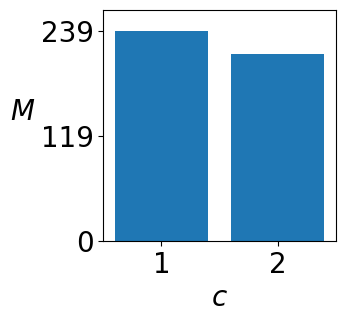

In [10]:
plt.figure(figsize=(3,3))
plt.bar(np.arange(len(new_group_number))+1, new_group_number)
plt.xlim([0.5,len(new_group_number)+0.5])
plt.xticks(list(range(1,len(new_group_number)+1)),fontsize=20)
plt.ylim([0, np.max(new_group_number)*1.1])
plt.yticks([0, int(np.max(new_group_number)/2), int(np.max(new_group_number))],fontsize=20)
plt.xlabel(r"$c$",fontsize=20)
plt.ylabel(r"$M$",fontsize=20,rotation=0,horizontalalignment='right')
plt.show()

In [11]:
classifier = Classifier(similarity_func=topology_comparator, cluster_centers=[models[index] for index in center_indices])

n1 = 51
n2 = 51
g1s = np.linspace(-3,3,n1)
g2s = np.linspace(-3,3,n2)

v_list = np.zeros((n1,n2))

for i in range(n1):
    for j in range(n2):
        hamiltonian = LossGain1D(E_ref=E_ref)
        hamiltonian.set_parameters(kappa=1, g1=g1s[i], g2=g2s[j])
        #print(hamiltonian.get_parameters())
        if hamiltonian.is_real_line_gap():
            _model = NonHermitianTopologicalModel(hamiltonian=hamiltonian, gap_type="real line")
            v_list[i,j] = classifier.classify(_model)

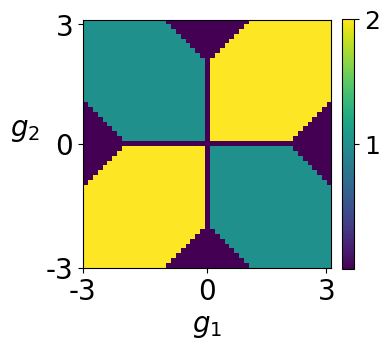

In [12]:
n1, n2 = v_list.shape

plt.figure(figsize=(4,4))
plt.imshow(np.transpose(v_list), origin='lower',extent = [0,n1,0,n2])
plt.xlabel(r"$g_1$",fontsize=20)
plt.ylabel(r"$g_2$",fontsize=20, rotation=0, horizontalalignment='right')
plt.xticks([0, n1/2, n1-1],[r"-3", r"0", r"3"],fontsize=20)
plt.yticks([0, n2/2, n2-1],[r"-3", r"0", r"3"], fontsize=20)

cb = plt.colorbar(ticks=range(1, len(center_indices)+1), fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.show()

# Save data

In [13]:
from tools import save_data, save_data_M

name = "1D_loss_gain_real"
save_data(new_center_indices, new_group_number, "fig2_{0}_group_number.h5".format(name))
save_data_M(v_list, "fig2_{0}_phase_diagram.h5".format(name))
print(name)

1D_loss_gain_real
